In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from plotnine import *


import itertools
from model_functions import calc_iv, convert_dummy, get_category, plot_confusion_matrix, plot_importance


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#Neural network
from keras import models
from keras import layers
from keras import optimizers



In [2]:
data = pd.read_csv("../input/application_record.csv") 
record = pd.read_csv("../input/credit_record.csv")  
sns.set_style('white')

# Feature Engineering

## Response Variable

In [3]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

In [4]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [5]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0
print(cpunt['dep_value'].value_counts())
display(cpunt['dep_value'].value_counts(normalize=True))

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

## Features

In [6]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

## Binary Features

In [7]:
#Gender
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
display(data.head())

0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


In [8]:
#Car
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
display(data.head())

0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


In [9]:
#House
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
display(data.head())

1    16461
0     8673
Name: Reality, dtype: int64
This variable's IV is: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


In [10]:
#Phone
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
This variable's IV is: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


In [11]:
#Email
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
display(data.head())

0    0.89934
1    0.10066
Name: email, dtype: float64
This variable's IV is: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


In [12]:
#Workphone
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
display(data.head())

This variable's IV is: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


## Continuous Variables¶

In [13]:
#number of children
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
display(data.head())
new_data = convert_dummy(new_data,'ChldNo')

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64
This variable's IV is: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


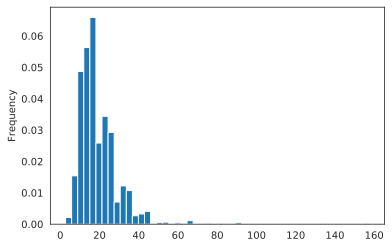

In [14]:
#Annual income
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [15]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()
new_data = convert_dummy(new_data,'gp_inc')

This variable's IV is: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


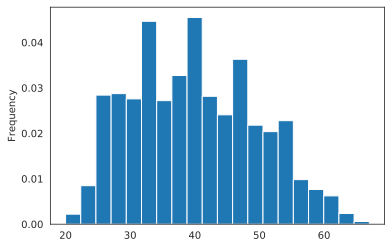

In [16]:
#AGE
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [17]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()
new_data = convert_dummy(new_data,'gp_Age')

This variable's IV is: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


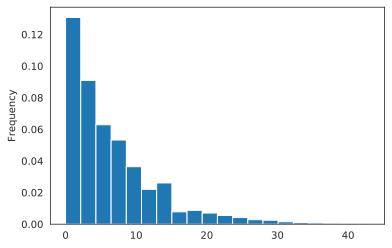

In [18]:
#Years working
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['worktm']<0] = np.nan 
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) 
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [19]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()
new_data = convert_dummy(new_data,'gp_worktm')

This variable's IV is: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


In [20]:
#Family size
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()
new_data = convert_dummy(new_data,'famsizegp')

This variable's IV is: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


## Categorical features

In [21]:
#Income type
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'inctp')

This variable's IV is: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


In [22]:
#Occupation type
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'occyp')

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


In [23]:
#House type
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'houtp')

This variable's IV is: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


In [24]:
#Education
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'edutp')

This variable's IV is: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


In [25]:
#Marriage status
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()
new_data = convert_dummy(new_data,'famtp')

This variable's IV is: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


# Weight of evidence & Information Values

In [26]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


# MODEL

In [27]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

In [28]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_sample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, stratify=Y_balance, test_size=0.3, random_state = 10086)

## Logistic regression

Accuracy Score is 0.6462773131912598
      0     1
0  4226  3188
1  2057  5357
[[0.5700027  0.4299973 ]
 [0.27744807 0.72255193]]


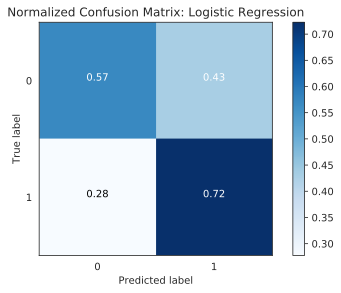

In [30]:
logit = LogisticRegression(random_state=0, solver='lbfgs')
clf = logit.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style("white") 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

## Decision tree

Accuracy Score is 0.9039654707310494
      0     1
0  6485   929
1   495  6919
[[0.87469652 0.12530348]
 [0.06676558 0.93323442]]


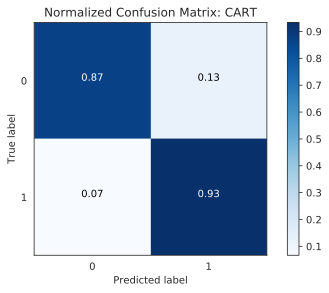

In [31]:
dt = DecisionTreeClassifier()
dtfit = dt.fit(X_train, y_train)
y_predict = dtfit.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

## Random Forest

Accuracy Score is 0.9050445103857567
      0     1
0  6498   916
1   492  6922
[[0.87644996 0.12355004]
 [0.06636094 0.93363906]]


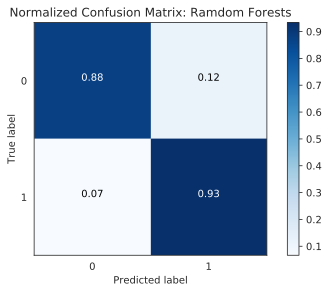

In [32]:
rf = RandomForestClassifier(n_estimators=50)
rffit = rf.fit(X_train, y_train)
y_predict = rffit.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

## SVM

Accuracy Score is 0.6390612355004046
      0     1
0  3605  3809
1  1543  5871
[[0.48624224 0.51375776]
 [0.20811977 0.79188023]]


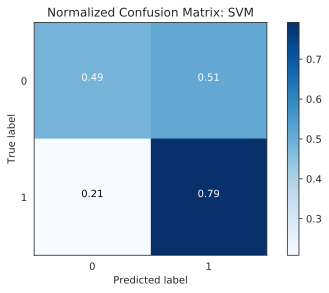

In [33]:
model = svm.SVC(kernel='linear', C = 1)
svmc = model.fit(X_train, y_train)
y_predict = svmc.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')

In [34]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### LightGBM

In [35]:
lgb = LGBMClassifier()
lgbfit = lgb.fit(X_train, y_train)
y_predict = lgbfit.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.8802940383059077
      0     1
0  6399  1015
1   760  6654


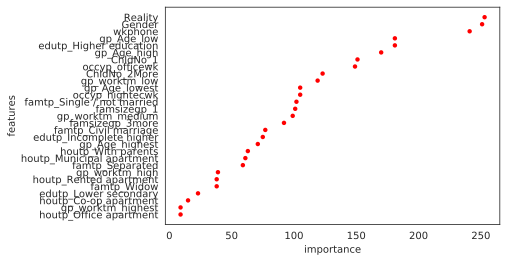

In [36]:
plot_importance(lgb, X_train,20) 

### XGBOOST

In [37]:
xgb = XGBClassifier()
xgbfit = xgb.fit(X_train, y_train)
y_predict = xgbfit.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.8966145130833558
      0     1
0  6428   986
1   547  6867


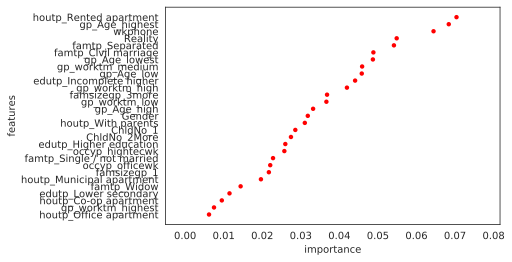

In [38]:
plot_importance(xgb, X_train, 20)   

## Neural network

In [39]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,089
Trainable params: 5,089
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])
history = model.fit(X_train, y_train,
    epochs = 64,
    batch_size = 128,
    validation_data = (X_test, y_test))

Epoch 1/64
271/271 [==============================] - 0s 1ms/step - loss: 0.5886 - accuracy: 0.6859 - val_loss: 0.5451 - val_accuracy: 0.7163
Epoch 2/64
271/271 [==============================] - 0s 844us/step - loss: 0.4798 - accuracy: 0.7713 - val_loss: 0.4514 - val_accuracy: 0.7905
Epoch 3/64
271/271 [==============================] - 0s 863us/step - loss: 0.4192 - accuracy: 0.8138 - val_loss: 0.4028 - val_accuracy: 0.8222
Epoch 4/64
271/271 [==============================] - 0s 872us/step - loss: 0.3821 - accuracy: 0.8325 - val_loss: 0.3734 - val_accuracy: 0.8295
Epoch 5/64
271/271 [==============================] - 0s 819us/step - loss: 0.3568 - accuracy: 0.8445 - val_loss: 0.3833 - val_accuracy: 0.8178
Epoch 6/64
271/271 [==============================] - 0s 964us/step - loss: 0.3389 - accuracy: 0.8509 - val_loss: 0.3426 - val_accuracy: 0.8458
Epoch 7/64
271/271 [==============================] - 0s 901us/step - loss: 0.3261 - accuracy: 0.8570 - val_loss: 0.3569 - val_accuracy: 0

271/271 [==============================] - 0s 832us/step - loss: 0.2482 - accuracy: 0.8882 - val_loss: 0.2871 - val_accuracy: 0.8756
Epoch 58/64
271/271 [==============================] - 0s 827us/step - loss: 0.2483 - accuracy: 0.8868 - val_loss: 0.2819 - val_accuracy: 0.8677
Epoch 59/64
271/271 [==============================] - 0s 881us/step - loss: 0.2468 - accuracy: 0.8887 - val_loss: 0.2589 - val_accuracy: 0.8889
Epoch 60/64
271/271 [==============================] - 0s 897us/step - loss: 0.2471 - accuracy: 0.8874 - val_loss: 0.2602 - val_accuracy: 0.8845
Epoch 61/64
271/271 [==============================] - 0s 815us/step - loss: 0.2472 - accuracy: 0.8886 - val_loss: 0.2931 - val_accuracy: 0.8704
Epoch 62/64
271/271 [==============================] - 0s 864us/step - loss: 0.2470 - accuracy: 0.8887 - val_loss: 0.2769 - val_accuracy: 0.8775
Epoch 63/64
271/271 [==============================] - 0s 844us/step - loss: 0.2463 - accuracy: 0.8908 - val_loss: 0.2685 - val_accuracy: 0.88

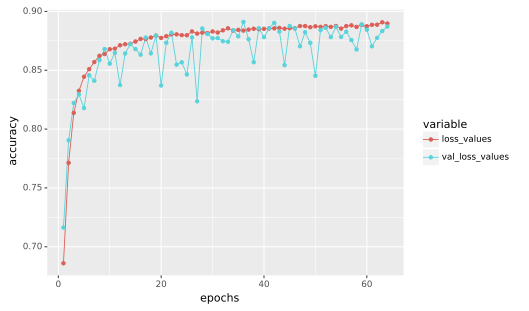

<ggplot: (8781238534232)>

In [41]:
history_dict = history.history
loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
cv_info = pd.DataFrame({'epochs':epochs,'loss_values':loss_values,'val_loss_values':val_loss_values})

cv_info = pd.melt(cv_info, id_vars=['epochs'], value_vars=['loss_values', 'val_loss_values'])

(
ggplot(cv_info,aes('epochs','value',color = 'variable')) +
geom_line() +
geom_point() +
labs(y = 'accuracy')
)